In [5]:
from slurmpy import Slurm
import numpy as np
import pandas as pd
import random

In [6]:
#plotly libraries
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio


#default renderer (svg means very small file size, visibility on github, high quality, but requires sometimes setting height and width)
pio.renderers.default = "svg"

colors = ["#363b3d", "#727b76", "#31a240", "#f93939", "#f79118", "#de7b06", "#9b308f", "#dc759b"]
#additional defaults
px.defaults.color_discrete_sequence = ["rgb(100,100,100)"] + pc.qualitative.D3
px.defaults.width=1000
px.defaults.height=800


#try setting this as default for histograms
#fig.update_traces(marker_line_width=0.2)

#pio.templates["simple_white"].layout.template.data.Histogram["marker_line_width"] = 0.2


#set default template as "simple_white" (no background, no grid lines)
pio.templates["simple_white"].layout["yaxis"]["showgrid"] = True
pio.templates.default = "simple_white"

import numpy as np

import sklearn.metrics as metrics
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

colorscale = pc.sequential.Plasma
print(colorscale)
colorscale = [colorscale[0]] + colorscale[3:8]
colorscale

['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a', '#fdca26', '#f0f921']


['#0d0887', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a']

In [9]:
rf_dir = "/vol/projects/pbohn/tools/RNAFramework"
data_folder = "/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data/"


reference_fasta = f"{data_folder}/references/transcripts_PCR1/RT1_unspliced1.fa"
reference_dir = f"{data_folder}/references/transcripts_PCR1"
samtools_path = "/home/pbohn/miniconda3/envs/nanodms/bin/samtools"


In [10]:
import pandas as pd
samplesheet = pd.read_excel("../SRA_samplesheet.xlsx", engine="openpyxl")

samples = samplesheet[samplesheet["[custom] experiment"] == "HIV1_unspliced"]["Sample"].values
samples = [sample for sample in samples if "cell" in sample]

In [11]:
from slurmpy import Slurm
pids = {}

# Rf-count and rf-norm with different settings

In [12]:
subsample_sizes = [500,1000,2000,4000, 5000, 7500, 10000, 15000, 20000, 30000]
num_subsamples = 20

In [ ]:
def rf_count_subsamples_settings(data_folder, bam_dir, rc_outdir, reference_fasta, settings, num_subsamples = 20, num_threads = 2, start_iteration = 1):

    slurm_rfcount = Slurm("rfcount", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "300","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

    commands = []
    
    for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
        bam_file = f"{bam_dir}/{iteration}.bam"
        for setting in settings:
            settings_name = setting.replace(" ", "").replace("-", "_")
            commands.append(f"{rf_dir}/rf-count -p {num_threads} -mf {primer_mask} -o {rc_outdir}/{iteration}_{settings_name} {setting} -ow -f {reference_fasta} -m {bam_file}")
            
    command = "\n".join(commands)
    
    pid = slurm_rfcount.run(command)
    return pid

In [ ]:
#rfnorm requires: perl-xml-libxml

rc_outdir = f"{data_folder}/subsample_rfcount/{sample}/{subsample_mean_coverage}/"


def rf_norm_subsampling_settings(rf_dir, data_folder, sample, control, subsample_size, num_subsamples, settings, start_iteration = 1, num_threads = 2):

    slurm_rfnorm = Slurm("rfnorm", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "480","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

    commands = []
    
    for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
    
        for setting in settings:
            settings_name = setting.replace(" ", "").replace("-", "_")
            
            for reactive_nt in ["AC", "ACT", "ACGT"]:

                rc_file = f"{data_folder}/subsample_rfcount/{sample}/{subsample_size}/{iteration}_{settings_name}/{iteration}.rc"

                control_rc_file = f"{data_folder}/subsample_rfcount/{control}/{subsample_size}/{iteration}_{settings_name}/{iteration}.rc"

                rfnorm_outdir = f"{data_folder}/subsample_rfnorm/{sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}"

                if sample != control:
                    os.makedirs(rfnorm_outdir, exist_ok=True)
                    commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -u {control_rc_file} -o {rfnorm_outdir} --scoring-method 3 --norm-method 2 -rb {reactive_nt} --max-untreated-mut 0.05 --max-mutation-rate 0.2 --norm-independent -ow")

                rfnorm_outdir = f"{data_folder}/subsample_rfnorm/{sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}_raw"
                os.makedirs(rfnorm_outdir, exist_ok=True)
                commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -o {rfnorm_outdir} --scoring-method 4 -r -rb {reactive_nt} -ow")

    command = "\n".join(commands)
    
    pid = slurm_rfnorm.run(command)
    return pid

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np

def read_in_xml(xml_file, sample, with_stdev = False):

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    transcript_id = root[0].attrib["id"]
    length = root[0].attrib["length"]
    sequence = root[0][0].text.replace("\t", "").replace("\n", "")
    reactivity = np.array(root[0][1].text.replace("\t", "").replace("\n", "").split(",")).astype(float)
    if with_stdev:
        stdev = np.array(root[0][2].text.replace("\t", "").replace("\n", "").split(",")).astype(float)
        return {"sample" : sample, 
            "transcript_id" : transcript_id,
            "length" : length,
            "sequence" : sequence, 
            "reactivity" : reactivity,
            "stdev": stdev
           }
    else:
        return {"sample" : sample, 
            "transcript_id" : transcript_id,
            "length" : length,
            "sequence" : sequence, 
            "reactivity" : reactivity
           }
    
    
def convert_xml_to_bpseq(xml_file,outfile):

    tmp_data = read_in_xml(xml_file, "")

    reactivities = tmp_data["reactivity"]
    sequence = list(tmp_data["sequence"].replace("T", "U"))
    
    reactivities = np.nan_to_num(reactivities, nan=-1.0)
    with open(outfile, "w+") as out:
        for i in np.arange(1,1+reactivities.shape[0]):
            position = int(i)
            line = f"{position} {sequence[position-1]} e1 {reactivities[position-1]}\n"
            out.write(line)
            
            
def convert_xml_to_bpseq_trimmed(xml_file,outfile, length):

    tmp_data = read_in_xml(xml_file, "")

    reactivities = tmp_data["reactivity"][:length]
    sequence = list(tmp_data["sequence"].replace("T", "U"))[:length]
    
    reactivities = np.nan_to_num(reactivities, nan=-1.0)
    with open(outfile, "w+") as out:
        for i in np.arange(1,1+reactivities.shape[0]):
            position = int(i)
            line = f"{position} {sequence[position-1]} e1 {reactivities[position-1]}\n"
            out.write(line)

### Compare default vs default_nd_ni

In [366]:
settings = ["", "-nd -ni"]


In [ ]:
import os

primer_mask = f"{data_folder}/references/mask_primers_PCR1_2_3.csv"
pids["rfcount"] = {}
for sample in samples:
    pids["rfcount"][sample] = {}

    os.makedirs(f"{data_folder}/subsample_bam/{sample}", exist_ok=True)
    for subsample_mean_coverage in subsample_sizes:

        bam_dir = f"{data_folder}/subsample_bam/{sample}/{subsample_mean_coverage}/"
        rc_outdir = f"{data_folder}/subsample_rfcount/{sample}/{subsample_mean_coverage}/"
        os.makedirs(rc_outdir, exist_ok=True)

        pids["rfcount"][sample][f"{subsample_mean_coverage}"] = rf_count_subsamples_settings(data_folder, bam_dir, rc_outdir, reference_fasta, settings, num_threads = 2)


### Rf-norm

In [ ]:
os.makedirs(f"{data_folder}/subsample_rfnorm/", exist_ok=True)


pids["rfnorm"] = {}
for sample in samples:
    pids["rfnorm"][sample] = {}
    os.makedirs(f"{data_folder}/subsample_rfnorm/{sample}", exist_ok=True)
    for subsample_size in subsample_sizes:
        os.makedirs(f"{data_folder}/subsample_rfnorm/{sample}/{subsample_size}", exist_ok=True)

        split_sample = sample.split("_")
        split_sample[2] = "0mM"
        control = "_".join(split_sample)
        
        pids["rfnorm"][sample][f"{subsample_mean_coverage}"] = rf_norm_subsampling_settings(rf_dir, data_folder, sample, control, subsample_size, num_subsamples, settings, num_threads = 2)

In [ ]:
os.makedirs("data/subsample_rfcombine", exist_ok=True)
num_threads = 1
slurm_rfco = Slurm("rfco", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "60","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

start_iteration = 1
num_subsamples = 20

os.makedirs(f"{data_folder}/subsample_rfnorm/", exist_ok=True)

pids["rfcombine"] = {}
for sample in samples:
    if ("Rep1" in sample):
        

        combined_sample = "_".join(sample.split("_")[1:])
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")
        
        os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}", exist_ok=True)
        
        for subsample_size in subsample_sizes:
            commands = []
            
            os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}", exist_ok=True)
            
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    
                    for reactive_nt in [ "AC", "ACT", "ACGT"]:

                        if "_0mM" in combined_sample:
                            norm_options = ["_raw"]
                        else:
                            norm_options = ["", "_raw"]
                            
                        for norm_option in norm_options:
                            xml1 = f"{data_folder}/subsample_rfnorm/{sample1}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"
                            xml2 = f"{data_folder}/subsample_rfnorm/{sample2}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"


                            xml_combined = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/"

                            commands.append(f"{rf_dir}/rf-combine -d 6 -o {xml_combined} -ow {xml1} {xml2}")

                            outfile = f"{xml_combined}/correlation.csv"

                            commands.append(f"{rf_dir}/rf-correlate -o {outfile} -ow {xml1} {xml2}")
            command = "\n".join(commands)
            pids["rfcombine"][f"{sample}_{subsample_size}"] = slurm_rfco.run(command)

In [ ]:
isoform = "RT1_unspliced1"

for sample in samples:
    if ("Rep1" in sample):
        

        combined_sample = "_".join(sample.split("_")[1:])
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")

        for subsample_size in subsample_sizes:     
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    for reactive_nt in [ "AC", "ACT", "ACGT"]:

                        if "_0mM" in combined_sample:
                            norm_options = ["_raw"]
                        else:
                            norm_options = ["", "_raw"]
                            
                        for norm_option in norm_options:

                            xml_combined = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/{isoform}.xml"

                            file = read_in_xml(xml_combined, combined_sample)
                            reactivities = file["reactivity"]
                            reactivities = np.nan_to_num(reactivities, nan = -1)
                            reactivity_file = xml_combined.replace(".xml", ".csv")
                            np.savetxt(reactivity_file, reactivities, fmt="%6f")
                            bp_file = xml_combined.replace(".xml", ".bp2seq")
                            convert_xml_to_bpseq(xml_combined, bp_file)
                            length = 380
                            bp_file = bp_file.replace(".bp2seq", f"_{length}nt.bp2seq")
                            convert_xml_to_bpseq_trimmed(xml_combined,bp_file, length)


## Screen per read median qscore filter for nd_ni

In [368]:
settings = [f"-nd -ni -eq {i}" for i in np.arange(10,31,2)]

In [ ]:
primer_mask = f"{data_folder}/references/mask_primers_PCR1_2_3.csv"
pids["rfcount"] = {}
for sample in samples:
    pids["rfcount"][sample] = {}

    os.makedirs(f"{data_folder}/subsample_bam/{sample}", exist_ok=True)
    for subsample_mean_coverage in subsample_sizes:

        bam_dir = f"{data_folder}/subsample_bam/{sample}/{subsample_mean_coverage}/"
        rc_outdir = f"{data_folder}/subsample_rfcount/{sample}/{subsample_mean_coverage}/"
        os.makedirs(rc_outdir, exist_ok=True)

        pids["rfcount"][sample][f"{subsample_mean_coverage}"] = rf_count_subsamples_settings(data_folder, bam_dir, rc_outdir, reference_fasta, settings, num_threads = 2)


In [ ]:
os.makedirs(f"{data_folder}/subsample_rfnorm/", exist_ok=True)


pids["rfnorm"] = {}
for sample in samples:
    pids["rfnorm"][sample] = {}
    os.makedirs(f"{data_folder}/subsample_rfnorm/{sample}", exist_ok=True)
    for subsample_size in subsample_sizes:
        os.makedirs(f"{data_folder}/subsample_rfnorm/{sample}/{subsample_size}", exist_ok=True)

        split_sample = sample.split("_")
        split_sample[2] = "0mM"
        control = "_".join(split_sample)
        
        pids["rfnorm"][sample][f"{subsample_mean_coverage}"] = rf_norm_subsampling_settings(rf_dir, data_folder, sample, control, subsample_size, num_subsamples, settings, num_threads = 2)

In [ ]:
os.makedirs("data/subsample_rfcombine", exist_ok=True)
num_threads = 1
slurm_rfco = Slurm("rfco", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "60","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

start_iteration = 1
num_subsamples = 20

os.makedirs(f"{data_folder}/subsample_rfnorm/", exist_ok=True)

pids["rfcombine"] = {}
for sample in samples:
    if ("Rep1" in sample):
        

        combined_sample = "_".join(sample.split("_")[1:])
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")
        
        os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}", exist_ok=True)
        
        for subsample_size in subsample_sizes:
            commands = []
            
            os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}", exist_ok=True)
            
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    
                    for reactive_nt in [ "AC", "ACT", "ACGT"]:

                        if "_0mM" in combined_sample:
                            norm_options = ["_raw"]
                        else:
                            norm_options = ["", "_raw"]
                            
                        for norm_option in norm_options:
                            xml1 = f"{data_folder}/subsample_rfnorm/{sample1}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"
                            xml2 = f"{data_folder}/subsample_rfnorm/{sample2}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"


                            xml_combined = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/"

                            commands.append(f"{rf_dir}/rf-combine -d 6 -o {xml_combined} -ow {xml1} {xml2}")

                            outfile = f"{xml_combined}/correlation.csv"

                            commands.append(f"{rf_dir}/rf-correlate -o {outfile} -ow {xml1} {xml2}")
            command = "\n".join(commands)
            pids["rfcombine"][f"{sample}_{subsample_size}"] = slurm_rfco.run(command)

In [ ]:
isoform = "RT1_unspliced1"

for sample in samples:
    if ("Rep1" in sample):
        

        combined_sample = "_".join(sample.split("_")[1:])
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")

        for subsample_size in subsample_sizes:     
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    for reactive_nt in [ "AC", "ACT", "ACGT"]:

                        if "_0mM" in combined_sample:
                            norm_options = ["_raw"]
                        else:
                            norm_options = ["", "_raw"]
                            
                        for norm_option in norm_options:

                            xml_combined = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/{isoform}.xml"

                            file = read_in_xml(xml_combined, combined_sample)
                            reactivities = file["reactivity"]
                            reactivities = np.nan_to_num(reactivities, nan = -1)
                            reactivity_file = xml_combined.replace(".xml", ".csv")
                            np.savetxt(reactivity_file, reactivities, fmt="%6f")
                            bp_file = xml_combined.replace(".xml", ".bp2seq")
                            convert_xml_to_bpseq(xml_combined, bp_file)
                            length = 380
                            bp_file = bp_file.replace(".bp2seq", f"_{length}nt.bp2seq")
                            convert_xml_to_bpseq_trimmed(xml_combined,bp_file, length)


## Screen per position median qscore filter for eq_10_nd_ni

In [ ]:
settings = [f"-nd -ni -eq 10 -q {i}" for i in np.arange(10,31,2)]

In [ ]:
primer_mask = f"{data_folder}/references/mask_primers_PCR1_2_3.csv"
pids["rfcount"] = {}
for sample in samples:
    pids["rfcount"][sample] = {}

    os.makedirs(f"{data_folder}/subsample_bam/{sample}", exist_ok=True)
    for subsample_mean_coverage in subsample_sizes:

        bam_dir = f"{data_folder}/subsample_bam/{sample}/{subsample_mean_coverage}/"
        rc_outdir = f"{data_folder}/subsample_rfcount/{sample}/{subsample_mean_coverage}/"
        os.makedirs(rc_outdir, exist_ok=True)

        pids["rfcount"][sample][f"{subsample_mean_coverage}"] = rf_count_subsamples_settings(data_folder, bam_dir, rc_outdir, reference_fasta, settings, num_threads = 2)


In [ ]:
os.makedirs(f"{data_folder}/subsample_rfnorm/", exist_ok=True)


pids["rfnorm"] = {}
for sample in samples:
    pids["rfnorm"][sample] = {}
    os.makedirs(f"{data_folder}/subsample_rfnorm/{sample}", exist_ok=True)
    for subsample_size in subsample_sizes:
        os.makedirs(f"{data_folder}/subsample_rfnorm/{sample}/{subsample_size}", exist_ok=True)

        split_sample = sample.split("_")
        split_sample[2] = "0mM"
        control = "_".join(split_sample)
        
        pids["rfnorm"][sample][f"{subsample_mean_coverage}"] = rf_norm_subsampling_settings(rf_dir, data_folder, sample, control, subsample_size, num_subsamples, settings, num_threads = 2)

In [ ]:
os.makedirs("data/subsample_rfcombine", exist_ok=True)
num_threads = 1
slurm_rfco = Slurm("rfco", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "10","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

start_iteration = 1
num_subsamples = 20

os.makedirs(f"{data_folder}/subsample_rfnorm/", exist_ok=True)

pids["rfcombine"] = {}
for sample in samples:
    if ("Rep1" in sample):
        

        combined_sample = "_".join(sample.split("_")[1:])
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")
        
        os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}", exist_ok=True)
        
        for subsample_size in subsample_sizes:
            commands = []
            
            os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}", exist_ok=True)
            
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    
                    for reactive_nt in [ "AC", "ACT", "ACGT"]:

                        if "_0mM" in combined_sample:
                            norm_options = ["_raw"]
                        else:
                            norm_options = ["", "_raw"]
                            
                        for norm_option in norm_options:
                            xml1 = f"{data_folder}/subsample_rfnorm/{sample1}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"
                            xml2 = f"{data_folder}/subsample_rfnorm/{sample2}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"


                            xml_combined = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/"

                            commands.append(f"{rf_dir}/rf-combine -d 6 -o {xml_combined} -ow {xml1} {xml2}")

                            outfile = f"{xml_combined}/correlation.csv"

                            commands.append(f"{rf_dir}/rf-correlate -o {outfile} -ow {xml1} {xml2}")
            command = "\n".join(commands)
            pids["rfcombine"][f"{sample}_{subsample_size}"] = slurm_rfco.run(command)

In [ ]:
os.makedirs("data/subsample_rfcombine", exist_ok=True)
num_threads = 1
slurm_rfco = Slurm("rfco", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "60","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

start_iteration = 1
num_subsamples = 20

os.makedirs(f"{data_folder}/subsample_rfnorm/", exist_ok=True)

pids["rfcombine"] = {}
for sample in samples:
    if ("Rep1" in sample):
        

        combined_sample = "_".join(sample.split("_")[1:])
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")
        
        os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}", exist_ok=True)
        
        for subsample_size in subsample_sizes:
            commands = []
            
            os.makedirs(f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}", exist_ok=True)
            
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    
                    for reactive_nt in [ "AC", "ACT", "ACGT"]:

                        if "_0mM" in combined_sample:
                            norm_options = ["_raw"]
                        else:
                            norm_options = ["", "_raw"]
                            
                        for norm_option in norm_options:
                            xml1 = f"{data_folder}/subsample_rfnorm/{sample1}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"
                            xml2 = f"{data_folder}/subsample_rfnorm/{sample2}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}"


                            xml_combined = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/"

                            commands.append(f"{rf_dir}/rf-combine -d 6 -o {xml_combined} -ow {xml1} {xml2}")

                            outfile = f"{xml_combined}/correlation.csv"

                            commands.append(f"{rf_dir}/rf-correlate -o {outfile} -ow {xml1} {xml2}")
            command = "\n".join(commands)
            pids["rfcombine"][f"{sample}_{subsample_size}"] = slurm_rfco.run(command)

In [ ]:
isoform = "RT1_unspliced1"

for sample in samples:
    if ("Rep1" in sample):
        

        combined_sample = "_".join(sample.split("_")[1:])
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")

        for subsample_size in subsample_sizes:     
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    for reactive_nt in [ "AC", "ACT", "ACGT"]:

                        if "_0mM" in combined_sample:
                            norm_options = ["_raw"]
                        else:
                            norm_options = ["", "_raw"]
                            
                        for norm_option in norm_options:

                            xml_combined = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/{isoform}.xml"

                            file = read_in_xml(xml_combined, combined_sample)
                            reactivities = file["reactivity"]
                            reactivities = np.nan_to_num(reactivities, nan = -1)
                            reactivity_file = xml_combined.replace(".xml", ".csv")
                            np.savetxt(reactivity_file, reactivities, fmt="%6f")
                            bp_file = xml_combined.replace(".xml", ".bp2seq")
                            convert_xml_to_bpseq(xml_combined, bp_file)
                            length = 380
                            bp_file = bp_file.replace(".bp2seq", f"_{length}nt.bp2seq")
                            convert_xml_to_bpseq_trimmed(xml_combined,bp_file, length)


# ROC-AUC

In [ ]:
subsample_sizes = [500,1000,2000,4000, 5000, 7500, 10000, 15000, 20000, 30000]
num_subsamples = 20

In [372]:
samples

['Rep1_RT1_0mM_cell',
 'Rep1_RT1_8mM_cell',
 'Rep1_RT1_17mM_cell',
 'Rep1_RT1_34mM_cell',
 'Rep1_RT1_57mM_cell',
 'Rep1_RT1_85mM_cell',
 'Rep2_RT1_0mM_cell',
 'Rep2_RT1_8mM_cell',
 'Rep2_RT1_17mM_cell',
 'Rep2_RT1_34mM_cell',
 'Rep2_RT1_57mM_cell',
 'Rep2_RT1_85mM_cell']

In [373]:
combined_samples = [sample.replace("Rep1_", "") for sample in samples if "Rep1" in sample]


# Plotting

## Default vs ndni

In [387]:
settings = ["", "-nd -ni"]


In [390]:
tmp_data = []

isoform = "RT1_unspliced1"

for combined_sample in combined_samples:
    print(combined_sample)
    if not "_0mM" in combined_sample:
        for subsample_size in subsample_sizes:     
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    for reactive_nt in [ "AC", "ACT"]:
                        norm_option = ""

                        xml_file = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/{isoform}.xml"

                        tmp_dict = read_in_xml(xml_file, combined_sample)

                        tmp_dict["setting"] = settings_name
                        tmp_dict["reactive_nt"] = reactive_nt
                        tmp_dict["norm_option"] = norm_option
                        tmp_dict["i"] = iteration
                        tmp_dict["subsample_size"] = subsample_size

                        reactivity_file = xml_file.replace(f"{isoform}.xml", "correlation.csv")
                        try:
                            tmp_df = pd.read_csv(reactivity_file, sep=";", names=["isoform", "corr",  "p_value"])
                            corr = tmp_df["corr"].values[0]
                        except:
                            corr = np.nan

                        tmp_dict["xml_corr"] = corr

                        tmp_data.append(tmp_dict)

RT1_85mM_cell
RT1_85mM_cell
RT1_85mM_cell
RT1_85mM_cell
RT1_85mM_cell
RT1_85mM_cell


In [391]:
reactivity_df = pd.DataFrame(tmp_data)
reactivity_df

sample   transcript_id length  \
0      RT1_8mM_cell  RT1_unspliced1    544   
1      RT1_8mM_cell  RT1_unspliced1    544   
2      RT1_8mM_cell  RT1_unspliced1    544   
3      RT1_8mM_cell  RT1_unspliced1    544   
4      RT1_8mM_cell  RT1_unspliced1    544   
...             ...             ...    ...   
3995  RT1_85mM_cell  RT1_unspliced1    544   
3996  RT1_85mM_cell  RT1_unspliced1    544   
3997  RT1_85mM_cell  RT1_unspliced1    544   
3998  RT1_85mM_cell  RT1_unspliced1    544   
3999  RT1_85mM_cell  RT1_unspliced1    544   

                                               sequence  \
0     GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
1     GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
2     GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
3     GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
4     GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
...                                                 ...   
3995  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
3996  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
3997  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
3998  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
3999  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   

                                             reactivity setting reactive_nt  \
0     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...                  AC   
1     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...                 ACT   
2     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni          AC   
3     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni         ACT   
4     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...                  AC   
...                                                 ...     ...         ...   
3995  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni         ACT   
3996  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...                  AC   
3997  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...                 ACT   
3998  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni          AC   
3999  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni         ACT   

     norm_option   i  subsample_size  xml_corr  
0                  1             500  0.044958  
1                  1             500  0.021534  
2                  1             500  0.191723  
3                  1             500  0.194368  
4                  2             500  0.066071  
...          ...  ..             ...       ...  
3995              19           30000  0.783747  
3996              20           30000  0.928204  
3997              20           30000  0.846768  
3998              20           30000  0.931581  
3999              20           30000  0.744295  

[4000 rows x 11 columns]

In [392]:
from sklearn.metrics import roc_auc_score
def calc_AUC(reactivity, structure):
    if type(reactivity) != float:
        y_true = np.array(structure) == "."
        y_test = np.array(reactivity)
        #print(y_true)
        y_test = y_test[:len(y_true)]
        mask = ~np.isnan(y_test)
        return roc_auc_score(y_true[mask], y_test[mask])
    else:
        return np.nan
    

In [393]:
structure_file = f"{data_folder.replace('data_illumina', 'data')}/references/dimer_canonical_wo_sl_at_210.db"
with open(structure_file) as infile:
    name, sequence, structure = infile.readlines()
structure = list(structure.strip())
#structure

In [394]:
reactivity_df["rocauc"] = reactivity_df["reactivity"].apply(lambda x: calc_AUC(x, structure))

In [395]:
reactivity_df["DMS_conc"] = reactivity_df["sample"].apply(lambda x: x.split("_")[1])
reactivity_df["location"] = reactivity_df["sample"].apply(lambda x: x.split("_")[2])

In [404]:
os.makedirs("dataframes", exist_ok=True)
reactivity_df.to_pickle("dataframes/nanopore_default_vs_ndni_reactivity_subsampling.pickle.gz")

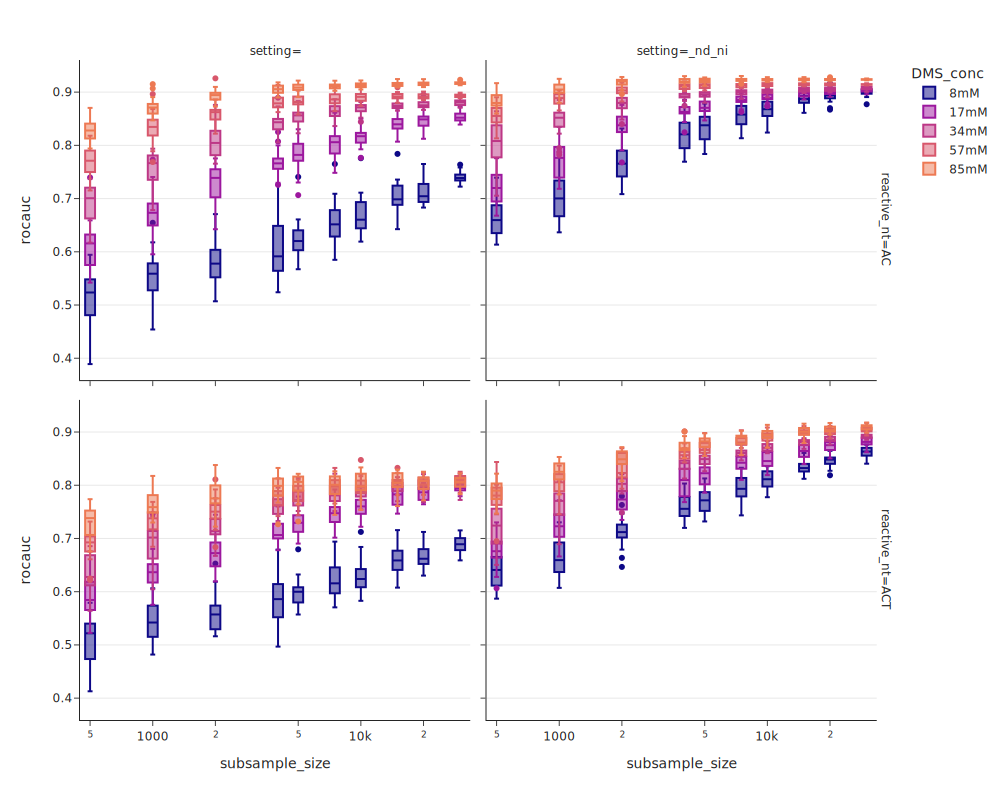

In [397]:
fig = px.box(reactivity_df, x="subsample_size", y="rocauc", boxmode="overlay",color="DMS_conc", facet_row="reactive_nt", facet_col="setting", color_discrete_sequence=colorscale)
fig.update_xaxes(type="log")

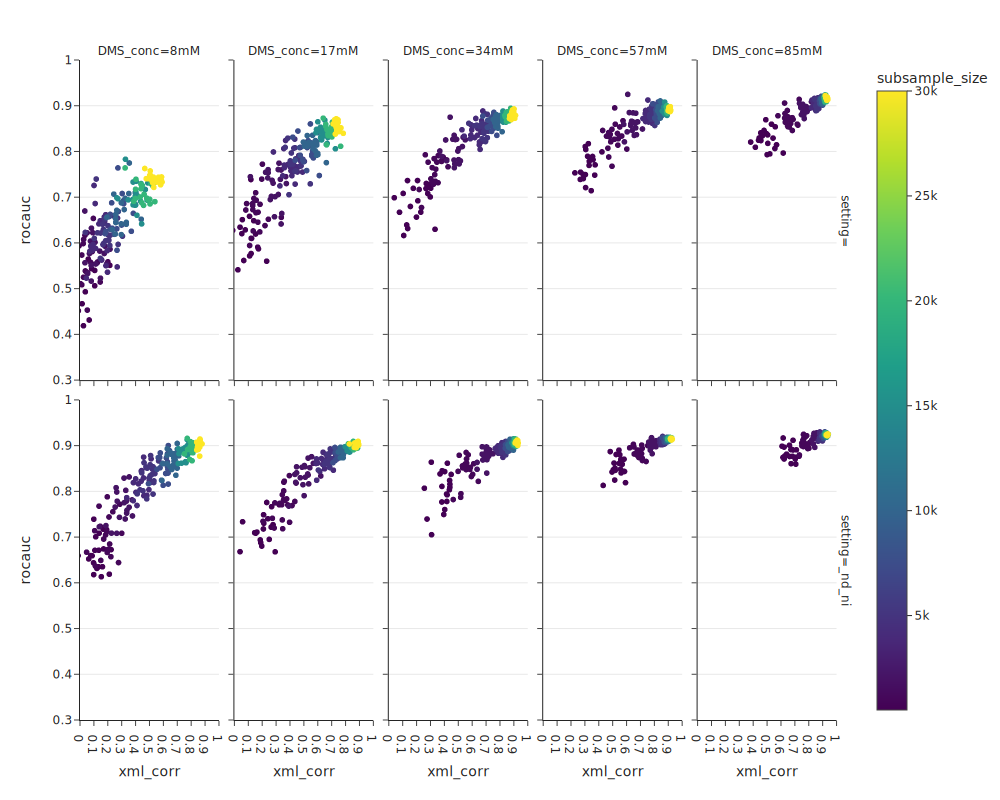

In [403]:
fig = px.scatter(reactivity_df[reactivity_df["reactive_nt"] == "AC"], x="xml_corr", color="subsample_size", y="rocauc", facet_col="DMS_conc", facet_row="setting")
fig.update_yaxes(range=[0.3, 1], dtick=0.1)
fig.update_xaxes(range=[0,1], dtick=0.1)

## Read median qscore filter

In [405]:
settings = [f"-nd -ni -eq {i}" for i in np.arange(10,31,2)]


In [407]:
tmp_data = []

isoform = "RT1_unspliced1"

for combined_sample in combined_samples:
    print(combined_sample)
    if not "_0mM" in combined_sample:
        for subsample_size in subsample_sizes:     
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    for reactive_nt in [ "AC"]:
                        norm_option = ""

                        xml_file = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/{isoform}.xml"

                        tmp_dict = read_in_xml(xml_file, combined_sample)

                        tmp_dict["setting"] = settings_name
                        tmp_dict["reactive_nt"] = reactive_nt
                        tmp_dict["norm_option"] = norm_option
                        tmp_dict["i"] = iteration
                        tmp_dict["subsample_size"] = subsample_size

                        reactivity_file = xml_file.replace(f"{isoform}.xml", "correlation.csv")
                        try:
                            tmp_df = pd.read_csv(reactivity_file, sep=";", names=["isoform", "corr",  "p_value"])
                            corr = tmp_df["corr"].values[0]
                        except:
                            corr = np.nan

                        tmp_dict["xml_corr"] = corr

                        tmp_data.append(tmp_dict)

RT1_0mM_cell
RT1_8mM_cell
RT1_17mM_cell
RT1_34mM_cell
RT1_57mM_cell
RT1_85mM_cell


In [408]:
reactivity_df = pd.DataFrame(tmp_data)
reactivity_df

sample   transcript_id length  \
0       RT1_8mM_cell  RT1_unspliced1    544   
1       RT1_8mM_cell  RT1_unspliced1    544   
2       RT1_8mM_cell  RT1_unspliced1    544   
3       RT1_8mM_cell  RT1_unspliced1    544   
4       RT1_8mM_cell  RT1_unspliced1    544   
...              ...             ...    ...   
10995  RT1_85mM_cell  RT1_unspliced1    544   
10996  RT1_85mM_cell  RT1_unspliced1    544   
10997  RT1_85mM_cell  RT1_unspliced1    544   
10998  RT1_85mM_cell  RT1_unspliced1    544   
10999  RT1_85mM_cell  RT1_unspliced1    544   

                                                sequence  \
0      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
1      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
2      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
3      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
4      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
...                                                  ...   
10995  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10996  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10997  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10998  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10999  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   

                                              reactivity      setting  \
0      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10   
1      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq12   
2      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq14   
3      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq16   
4      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq18   
...                                                  ...          ...   
10995  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq22   
10996  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq24   
10997  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq26   
10998  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq28   
10999  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq30   

      reactive_nt norm_option   i  subsample_size  xml_corr  
0              AC               1             500  0.157944  
1              AC               1             500  0.158280  
2              AC               1             500  0.166163  
3              AC               1             500  0.164463  
4              AC               1             500  0.181839  
...           ...         ...  ..             ...       ...  
10995          AC              20           30000  0.930971  
10996          AC              20           30000  0.930497  
10997          AC              20           30000  0.930566  
10998          AC              20           30000  0.930279  
10999          AC              20           30000  0.928590  

[11000 rows x 11 columns]

In [409]:
from sklearn.metrics import roc_auc_score
def calc_AUC(reactivity, structure):
    if type(reactivity) != float:
        y_true = np.array(structure) == "."
        y_test = np.array(reactivity)
        #print(y_true)
        y_test = y_test[:len(y_true)]
        mask = ~np.isnan(y_test)
        return roc_auc_score(y_true[mask], y_test[mask])
    else:
        return np.nan
    

In [410]:
structure_file = f"{data_folder.replace('data_illumina', 'data')}/references/dimer_canonical_wo_sl_at_210.db"
with open(structure_file) as infile:
    name, sequence, structure = infile.readlines()
structure = list(structure.strip())
#structure

In [413]:
reactivity_df["rocauc"] = reactivity_df["reactivity"].apply(lambda x: calc_AUC(x, structure))

In [419]:
reactivity_df["DMS_conc"] = reactivity_df["sample"].apply(lambda x: x.split("_")[1])
reactivity_df["location"] = reactivity_df["sample"].apply(lambda x: x.split("_")[2])

reactivity_df["eq"] = reactivity_df["setting"].apply(lambda x: int(x.split("_eq")[-1]))

In [420]:
os.makedirs("dataframes", exist_ok=True)
reactivity_df.to_pickle("dataframes/nanopore_ndni_read_median_qscore_reactivity_subsampling.pickle.gz")

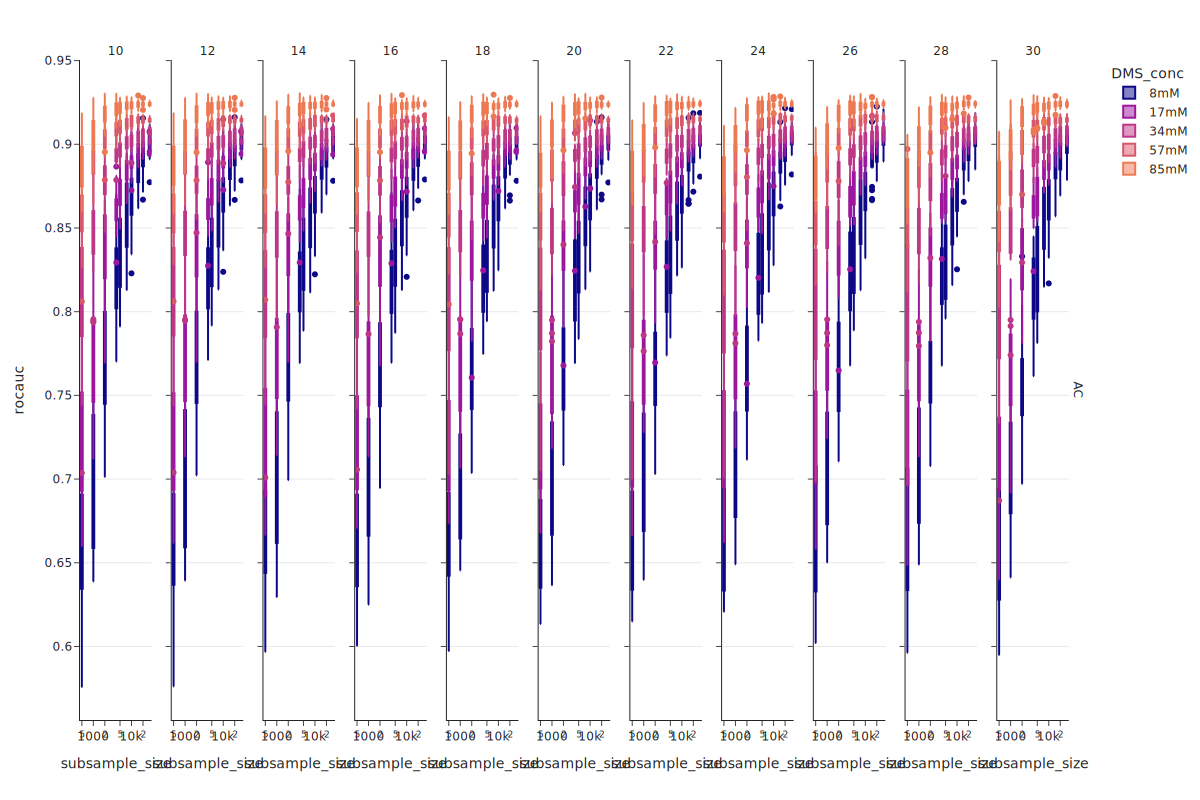

In [424]:
fig = px.box(reactivity_df, x="subsample_size", y="rocauc", boxmode="overlay",color="DMS_conc", facet_row="reactive_nt", facet_col="eq", color_discrete_sequence=colorscale)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(width=1200)
fig.update_xaxes(type="log")

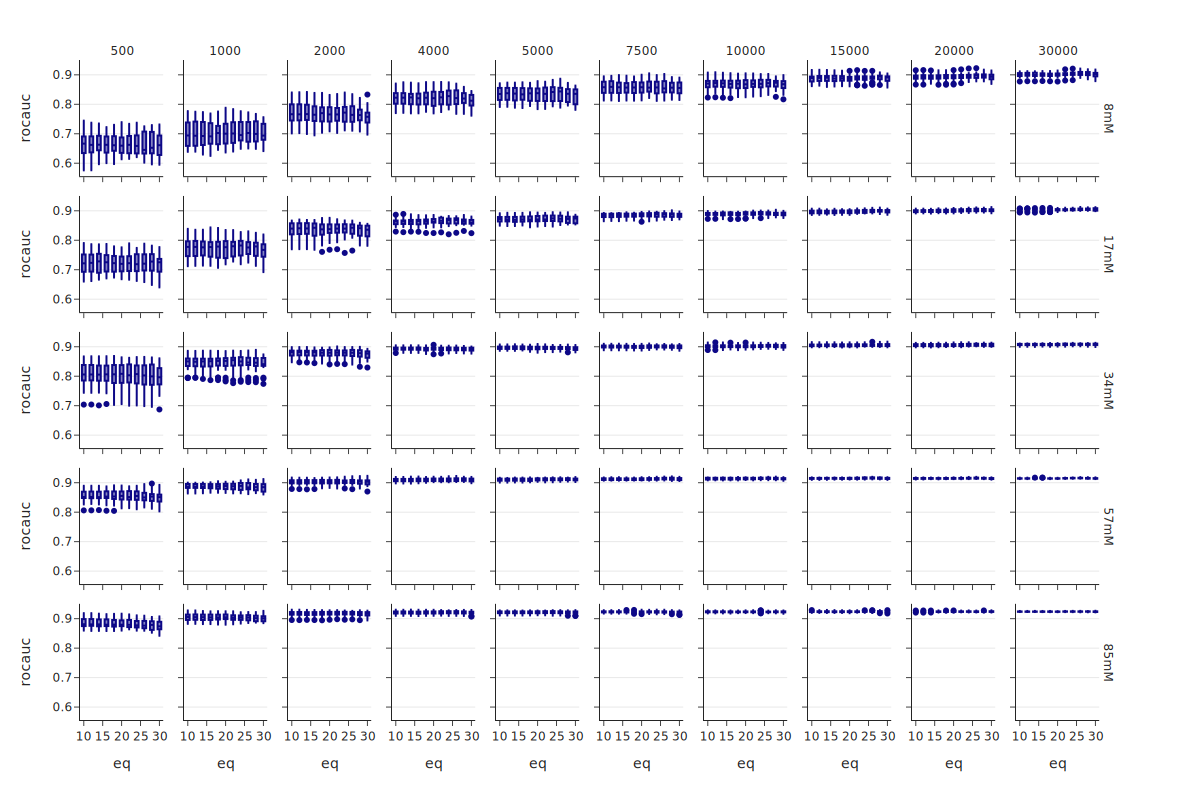

In [428]:
fig = px.box(reactivity_df, facet_col="subsample_size", y="rocauc", boxmode="overlay",facet_row="DMS_conc",  x="eq", color_discrete_sequence=colorscale)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(width=1200)

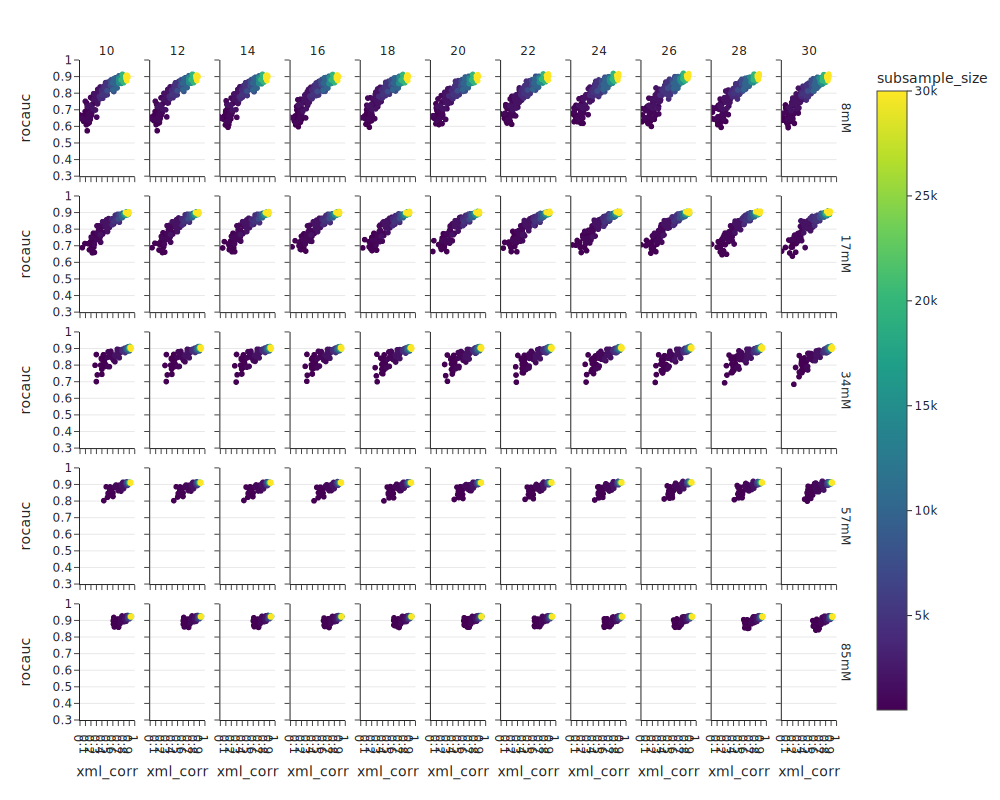

In [432]:
fig = px.scatter(reactivity_df, x="xml_corr", color="subsample_size", y="rocauc", facet_row="DMS_conc", facet_col="eq")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.update_yaxes(range=[0.3, 1], dtick=0.1)
fig.update_xaxes(range=[0,1], dtick=0.1)

## Position qscore filter

In [433]:
settings = [f"-nd -ni -eq 10 -q {i}" for i in np.arange(10,31,2)]

In [434]:
tmp_data = []

isoform = "RT1_unspliced1"

for combined_sample in combined_samples:
    print(combined_sample)
    if not "_0mM" in combined_sample:
        for subsample_size in subsample_sizes:     
            for iteration in np.arange(start_iteration,start_iteration+num_subsamples):
                for setting in settings:
                    settings_name = setting.replace(" ", "").replace("-", "_")
                    for reactive_nt in [ "AC"]:
                        norm_option = ""

                        xml_file = f"{data_folder}/subsample_rfcombine/{combined_sample}/{subsample_size}/{iteration}_{settings_name}_{reactive_nt}{norm_option}/{isoform}.xml"

                        tmp_dict = read_in_xml(xml_file, combined_sample)

                        tmp_dict["setting"] = settings_name
                        tmp_dict["reactive_nt"] = reactive_nt
                        tmp_dict["norm_option"] = norm_option
                        tmp_dict["i"] = iteration
                        tmp_dict["subsample_size"] = subsample_size

                        reactivity_file = xml_file.replace(f"{isoform}.xml", "correlation.csv")
                        try:
                            tmp_df = pd.read_csv(reactivity_file, sep=";", names=["isoform", "corr",  "p_value"])
                            corr = tmp_df["corr"].values[0]
                        except:
                            corr = np.nan

                        tmp_dict["xml_corr"] = corr

                        tmp_data.append(tmp_dict)

RT1_0mM_cell
RT1_8mM_cell
RT1_17mM_cell
RT1_34mM_cell
RT1_57mM_cell
RT1_85mM_cell


In [435]:
reactivity_df = pd.DataFrame(tmp_data)
reactivity_df

sample   transcript_id length  \
0       RT1_8mM_cell  RT1_unspliced1    544   
1       RT1_8mM_cell  RT1_unspliced1    544   
2       RT1_8mM_cell  RT1_unspliced1    544   
3       RT1_8mM_cell  RT1_unspliced1    544   
4       RT1_8mM_cell  RT1_unspliced1    544   
...              ...             ...    ...   
10995  RT1_85mM_cell  RT1_unspliced1    544   
10996  RT1_85mM_cell  RT1_unspliced1    544   
10997  RT1_85mM_cell  RT1_unspliced1    544   
10998  RT1_85mM_cell  RT1_unspliced1    544   
10999  RT1_85mM_cell  RT1_unspliced1    544   

                                                sequence  \
0      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
1      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
2      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
3      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
4      GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
...                                                  ...   
10995  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10996  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10997  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10998  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   
10999  GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...   

                                              reactivity          setting  \
0      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q10   
1      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q12   
2      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q14   
3      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q16   
4      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q18   
...                                                  ...              ...   
10995  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q22   
10996  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q24   
10997  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q26   
10998  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q28   
10999  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  _nd_ni_eq10_q30   

      reactive_nt norm_option   i  subsample_size  xml_corr  
0              AC               1             500  0.203373  
1              AC               1             500  0.085356  
2              AC               1             500  0.072144  
3              AC               1             500  0.016603  
4              AC               1             500  0.116640  
...           ...         ...  ..             ...       ...  
10995          AC              20           30000  0.929802  
10996          AC              20           30000  0.929204  
10997          AC              20           30000  0.927666  
10998          AC              20           30000  0.925231  
10999          AC              20           30000  0.923797  

[11000 rows x 11 columns]

In [436]:
from sklearn.metrics import roc_auc_score
def calc_AUC(reactivity, structure):
    if type(reactivity) != float:
        y_true = np.array(structure) == "."
        y_test = np.array(reactivity)
        #print(y_true)
        y_test = y_test[:len(y_true)]
        mask = ~np.isnan(y_test)
        return roc_auc_score(y_true[mask], y_test[mask])
    else:
        return np.nan
    

In [437]:
structure_file = f"{data_folder.replace('data_illumina', 'data')}/references/dimer_canonical_wo_sl_at_210.db"
with open(structure_file) as infile:
    name, sequence, structure = infile.readlines()
structure = list(structure.strip())
#structure

In [438]:
reactivity_df["rocauc"] = reactivity_df["reactivity"].apply(lambda x: calc_AUC(x, structure))

In [439]:
reactivity_df["DMS_conc"] = reactivity_df["sample"].apply(lambda x: x.split("_")[1])
reactivity_df["location"] = reactivity_df["sample"].apply(lambda x: x.split("_")[2])

reactivity_df["q"] = reactivity_df["setting"].apply(lambda x: int(x.split("_q")[-1]))

In [440]:
os.makedirs("dataframes", exist_ok=True)
reactivity_df.to_pickle("dataframes/nanopore_ndni_eq10_position_qscore_reactivity_subsampling.pickle.gz")

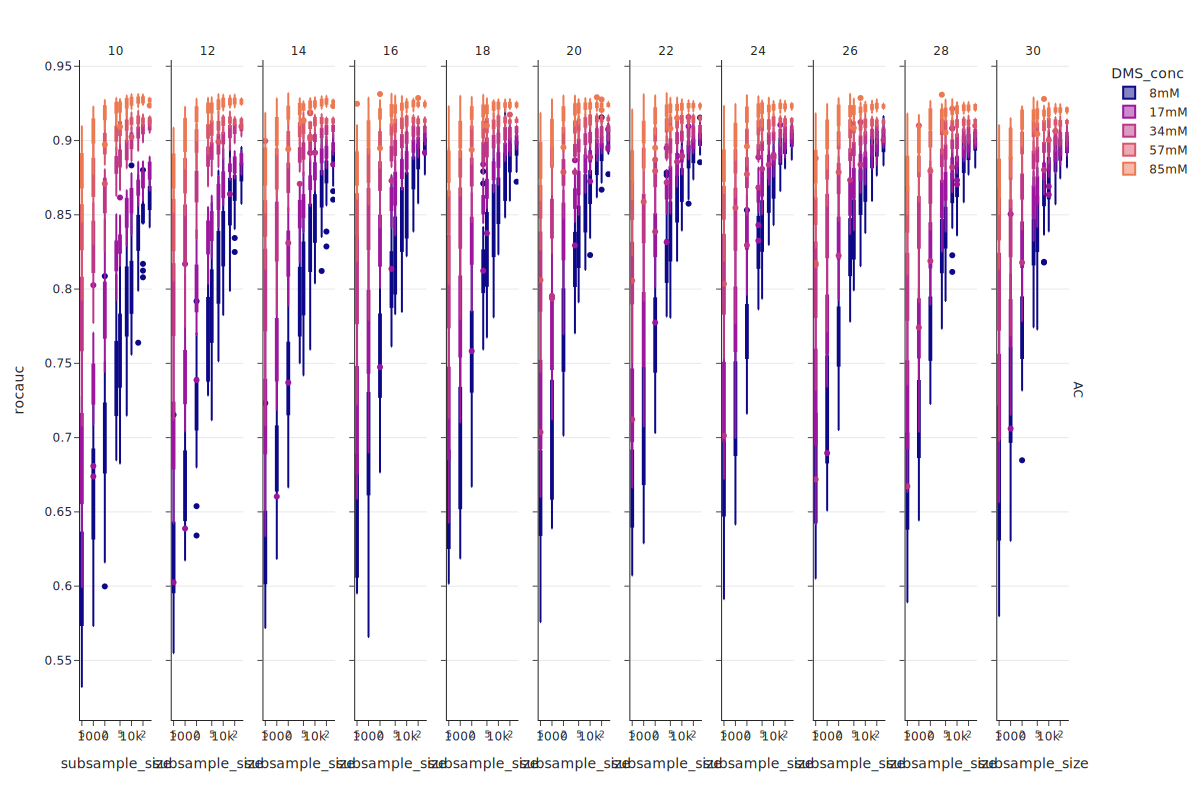

In [445]:
fig = px.box(reactivity_df, x="subsample_size", y="rocauc", boxmode="overlay",color="DMS_conc", facet_row="reactive_nt", facet_col="q", color_discrete_sequence=colorscale)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(width=1200)
fig.update_xaxes(type="log")

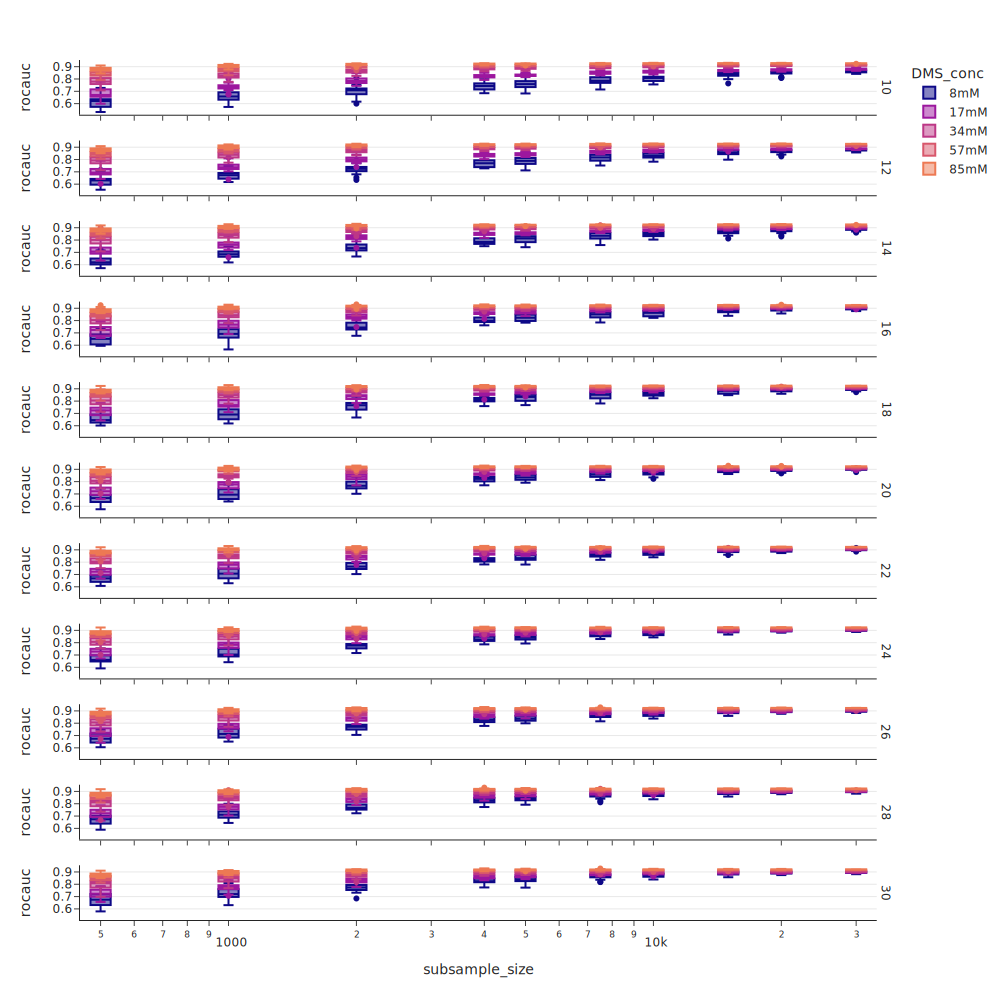

In [446]:
fig = px.box(reactivity_df, x="subsample_size", y="rocauc", boxmode="overlay",color="DMS_conc", facet_row="q", color_discrete_sequence=colorscale)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(height=1000)
fig.update_xaxes(type="log")

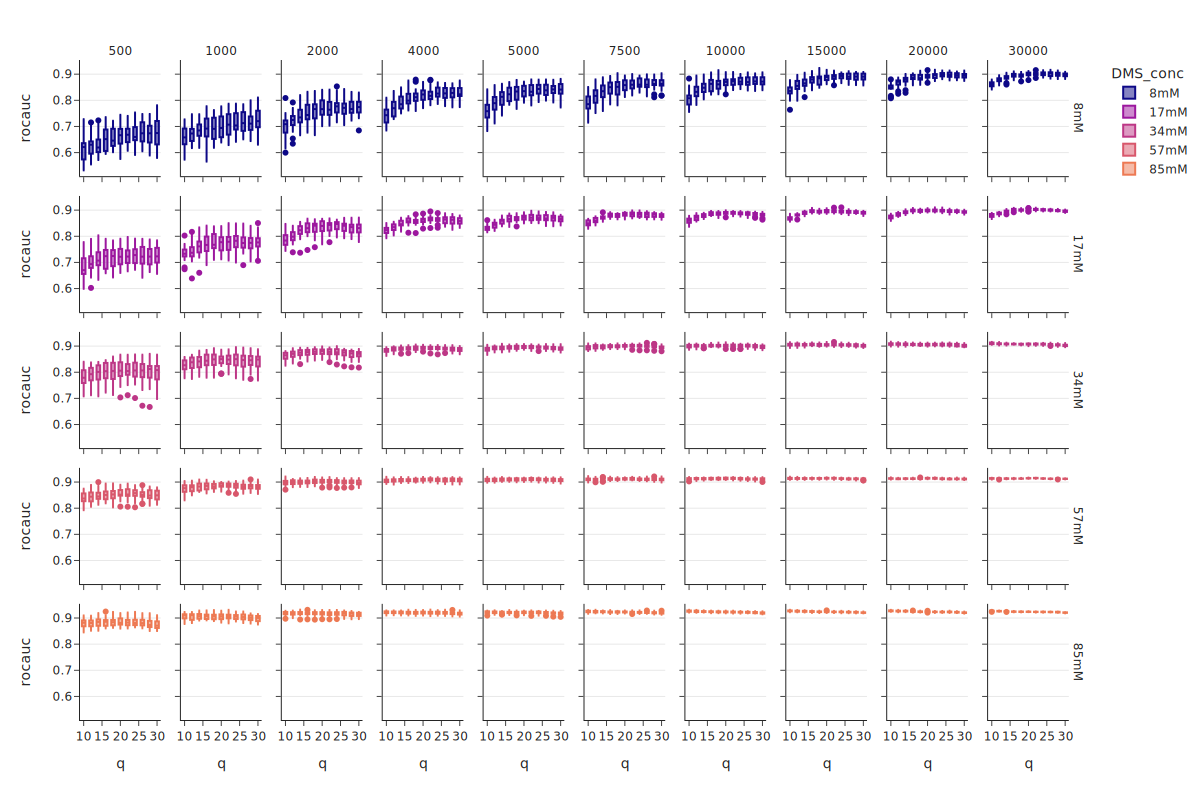

In [447]:
fig = px.box(reactivity_df, facet_col="subsample_size", y="rocauc", boxmode="overlay",facet_row="DMS_conc",  x="q", color="DMS_conc", color_discrete_sequence=colorscale)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(width=1200)

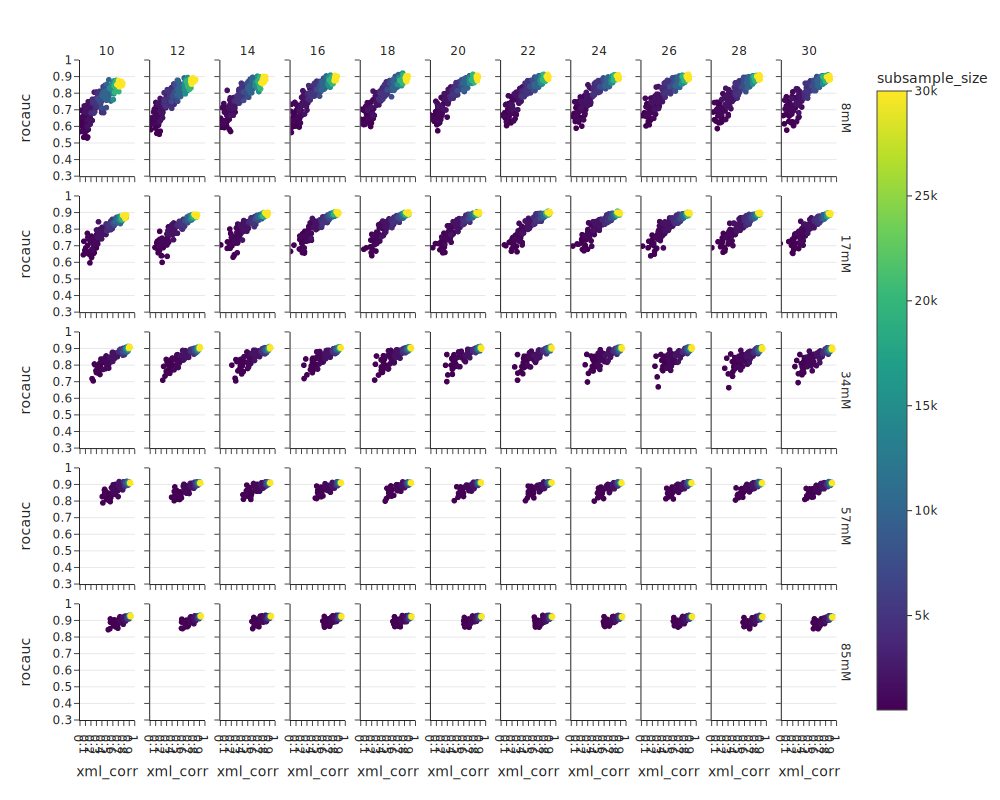

In [443]:
fig = px.scatter(reactivity_df, x="xml_corr", color="subsample_size", y="rocauc", facet_row="DMS_conc", facet_col="q")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.update_yaxes(range=[0.3, 1], dtick=0.1)
fig.update_xaxes(range=[0,1], dtick=0.1)

# Signal to noise ratio